# SDC - Lesson 4 - Lane Markings

### Masking and Color Selection (white)

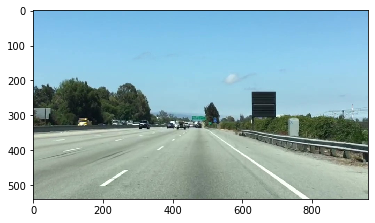

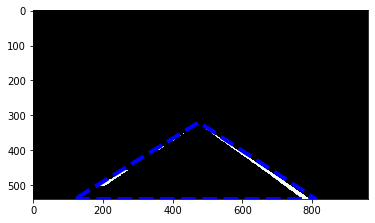

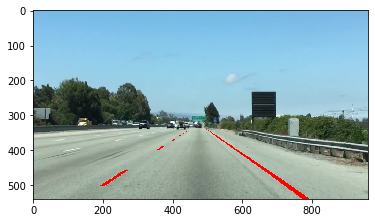

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [120, 540]
right_bottom = [810, 540]
apex = [475, 320]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
plt.imshow(image)
plt.show()
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
plt.show()
plt.imshow(line_image)
plt.show()

### Import OpenCV and apply Canny Edge Detection

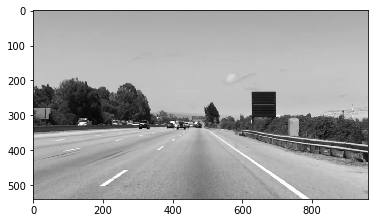

In [37]:
import cv2  #bringing in OpenCV libraries
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
#%matplotlib qt 
%matplotlib inline
plt.imshow(gray, cmap='gray')

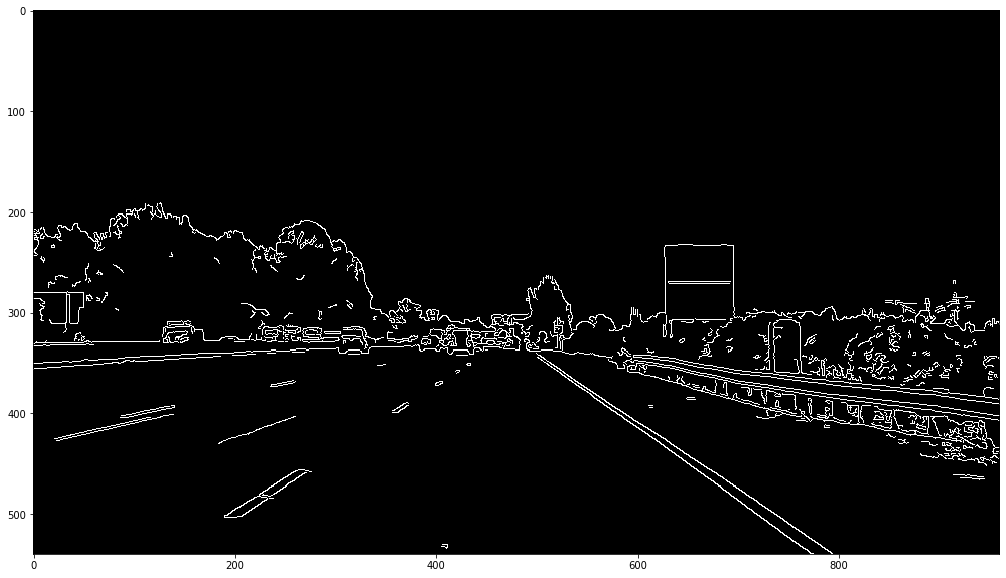

In [46]:
low_threshold = 100
high_threshold = 200
edges = cv2.Canny(gray, low_threshold, high_threshold)
plt.figure(figsize = (20,10))
plt.imshow(edges,cmap='gray')

### Canny Edge Detection plus additional Gaussian Filter

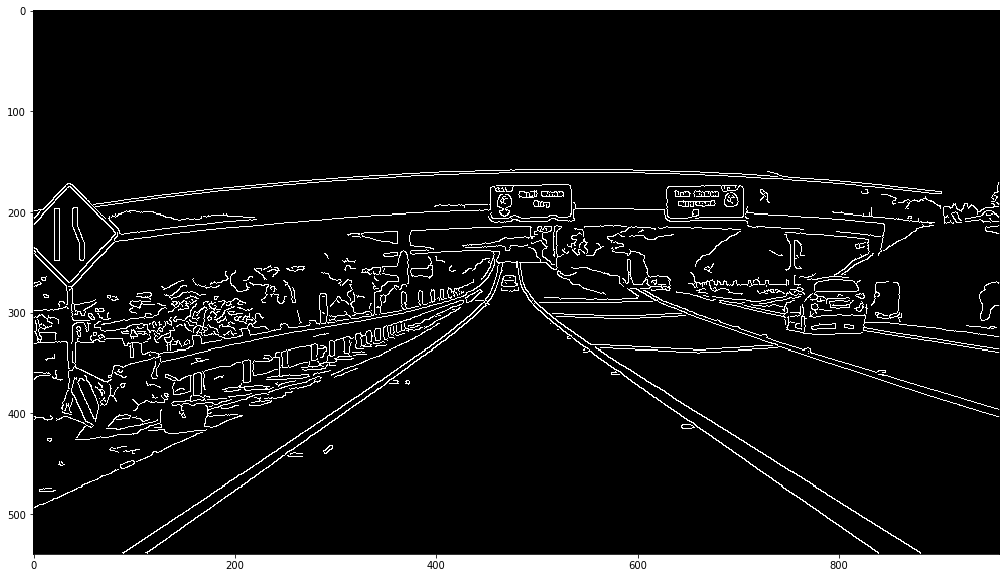

In [78]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and convert to grayscale
image = mpimg.imread('exit-ramp.jpg')
#image = mpimg.imread('test.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size = 3
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
# NOTE: if you try running this code you might want to change these!
low_threshold = 60
high_threshold = 120
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Display the image
plt.figure(figsize=(20,10))
plt.imshow(edges, cmap='Greys_r')

### Hough Transformation

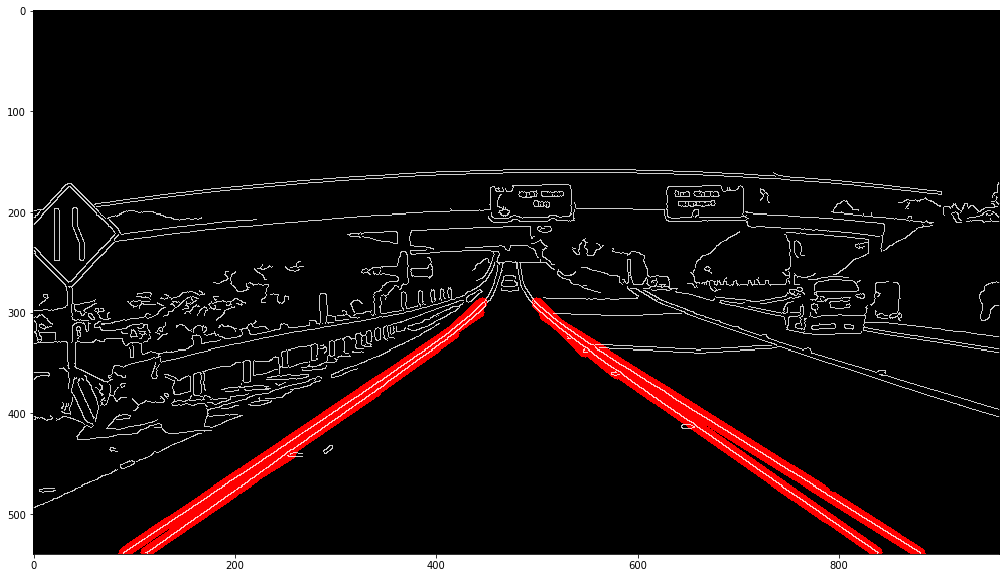

In [138]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2


# Read in and grayscale the image
image = mpimg.imread('exit-ramp.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(70,imshape[0]),(435, 290), (500, 290), (890,imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 20 # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
plt.figure(figsize=(20,10))
plt.imshow(lines_edges)